In [1]:
from neural_network import NeuralNetwork
from data import Instance, DataSet
from miscellaneous import initialize_data, plot_graph, plot_points
from activation_function import *
import matplotlib.pyplot as plt
import pandas as pd
import copy
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import itertools
import time
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.metrics import mean_squared_log_error
import random
warnings.filterwarnings('ignore')

Using TensorFlow backend.


#### Carregando dados e Ajustando labels

In [2]:
start_time = time.time()

# Carregando dados
print('Carregando dados ...', end = '')
champ_stats = pd.read_csv('../dataset/champ_stats.csv')
champs = pd.read_csv('../dataset/champs.csv')
mtime = pd.read_csv('../dataset/matches_MODIFIED.csv')
participants = pd.read_csv('../dataset/participants.csv')
stats1 = pd.read_csv('../dataset/stats1_MODIFIED.csv')
stats2 = pd.read_csv('../dataset/stats2_MODIFIED.csv')
stats = pd.concat([stats1, stats2])
print( 28*'.'+' OK')

# Ajustando nomes
print('Ajustando nomes[1] ...', end = '')
champ_stats_labels = [i.lower() for i in champ_stats.columns.values]
rename_dict_champ_stats = { i: j for i,j in zip(champ_stats.columns.values, champ_stats_labels) }
champ_stats.rename(columns = rename_dict_champ_stats, inplace = True)
print( 26*'.'+' OK')

# Ajustando nomes
print('Ajustando nomes[2] ...', end = '')
champs_labels = [i.lower() for i in champs.columns.values]
rename_dict_champs = { i: j for i,j in zip(champs.columns.values, champs_labels) }
champs.rename(columns = rename_dict_champs, inplace = True)
print( 26*'.'+' OK')

# Ajustando nomes e índices
print('Ajustando nomes[3] ...', end = '')
champ_stats['name'] = champ_stats['name'].str.replace('\'', '')
champ_stats['name'] = champ_stats['name'].str.replace('\. ', '')
champ_stats = champ_stats[champ_stats['name'].isin(champs['name'])].reset_index(drop = True)
champs = champs.sort_values('name').reset_index(drop = True)
print( 26*'.'+' OK')

# Reduzindo dimensionalidade
print('Reduzindo dimensionalidade ...', end = '')
params = ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'mr']
for param in params:
    champ_stats[param] = champ_stats[param] + 10*champ_stats[param+'+']
    champ_stats.drop(columns = [param+'+'], inplace = True)
    
champ_stats['as'] = champ_stats['as'] * ((1 + champ_stats['as+'])**10)
champ_stats.drop(columns = ['as+'], inplace = True)
print( 18*'.'+' OK')

# Removendo atributos desnecessários
print('Removendo atributos desnecessários ...', end = '')
#participants.drop(columns = ['player', 'ss1', 'ss2', 'id', 'matchid'], inplace = True)
participants.drop(columns = ['player', 'ss1', 'ss2'], inplace = True)
stats.drop(columns = ['trinket', 'assists', 'firstblood'], inplace = True)
print( 10*'.'+' OK')

# Juntando tabelas
print('Juntando tabelas ...', end = '')
participants.set_index('id', inplace = True)
stats.set_index('id', inplace = True)
dataset = pd.DataFrame.copy(participants)
dataset = dataset.join(pd.DataFrame.copy(stats))
print( 15*'.'+' OK')

# One-hot encoding para role e position
print('One-hot encoding para role e position ...', end = '')
dataset = pd.concat([dataset, pd.get_dummies( dataset['role'], prefix = 'role')],axis=1)
dataset = pd.concat([dataset, pd.get_dummies( dataset['position'], prefix = 'pos')],axis=1)
dataset.drop(['role', 'position'], axis = 1, inplace = True)
if 'role_DUO' not in dataset.columns.values:
    dataset['role_DUO'] = 0
print( 7*'.'+' OK        ')

# Substituindo IDs por nomes dos champions
print('Substituindo IDs por nomes dos champions ...', end = '')
s = champs.set_index('id')['name']
dataset['championid'] = dataset['championid'].replace(s)
print( 4*'.'+' OK       ')
        
# Juntando tabelas
print('Juntando tabelas ...', end = '')
params = ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'as', 'mr', 'ms', 'range']
s = champ_stats.set_index('name')
for param in params:
    dataset[param] = dataset['championid']
    dataset[param] = dataset[param].replace(s[param])
dataset = dataset.reset_index(drop = True)
print( 28*'.'+' OK')

# Normalizando parametros
print('Normalizando parâmetros ...', end = '')
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))
for col in ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'mr', 'ms', 'range']:
    dataset[col] = min_max_s.fit_transform(dataset[col].values.reshape(-1, 1))
print( 20*'.'+' OK')

# Removendo o nome dos champios
print('Removendo o nome dos champios ...', end = '')
dataset.drop(columns = ['championid'], inplace = True)
print( 15*'.'+' OK      ')

# Reconstruindo linhas apropriadamente
print('Reconstruindo linhas apropriadamente ...', end = '')
tmp = pd.DataFrame()
columnNames = dataset.columns.values.tolist()
p = 0
for i in range(2):
    for j in range(5):
        ij = str(i)+str(j)
        p = dataset[i*5+j::10].rename( columns = { name: name+ij for name in columnNames} )
        if(tmp.empty):
            tmp = pd.DataFrame.copy(p).reset_index(drop = True)
        else:
            tmp = tmp.join(pd.DataFrame.copy(p).reset_index(drop = True))
dataset = tmp
print( 8*'.'+' OK')

# Removendo dados duplicados
print('Removendo dados duplicados ...', end = '')
dataset.dropna()
dataset['matchid'] = dataset['matchid00']
dataset['win0'] = dataset['win00']
dataset['win1'] = dataset['win10']
dataset['kills0'] = dataset['kills00'] + dataset['kills01'] + dataset['kills02'] + dataset['kills03'] + dataset['kills04']
dataset['kills1'] = dataset['kills10'] + dataset['kills11'] + dataset['kills12'] + dataset['kills13'] + dataset['kills14']
dataset['deaths0'] = dataset['deaths00'] + dataset['deaths01'] + dataset['deaths02'] + dataset['deaths03'] + dataset['deaths04']
dataset['deaths1'] = dataset['deaths10'] + dataset['deaths11'] + dataset['deaths12'] + dataset['deaths13'] + dataset['deaths14']
dataset['kd_ratio0'] = dataset['kills0']/dataset['deaths0']
dataset['kd_ratio1'] = dataset['kills1']/dataset['deaths1']

for i in range(2):
    for j in range(5):
        ij = str(i)+str(j)
        dataset.drop(columns = ['win'+ij, 'kills'+ij, 'deaths'+ij, 'matchid'+ij], inplace = True)
    dataset.drop(columns = ['deaths'+str(i), 'kills'+str(i)], inplace = True)

dataset = dataset.join(mtime)
dataset.drop(columns = ['id', 'matchid'], inplace = True)
print( 8*'.'+' OK')

# 
print('Linhas antes de remover outliers: ' + str(dataset.shape[0]))
dataset = dataset[np.abs(dataset['duration']-dataset['duration'].mean())<=(3*dataset['duration'].std())]
print('Linhas depois de remover outliers: ' + str(dataset.shape[0]))

# Normalizando duração
print('Normalizando duração ...', end = '')
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))
for col in ['duration']:
    dataset[col] = min_max_s.fit_transform(dataset[col].values.reshape(-1, 1))
print( 20*'.'+' OK')

# Calculando dificuldade
print('Calculando dificuldade ...', end = '')
kd0 = pd.Series.copy(dataset['kd_ratio0'])
kd0[ kd0 > 1.0 ] = 1.0
kd0[ kd0 < 1.0 ] = 0.0
kd1 = 1.0 - kd0
win0 = dataset['win0']
win1 = dataset['win1']

durationTerm = 1.0 - dataset['duration']
killTerm = 0.5 + 0.5 * (dataset['kd_ratio0'] * kd1 + dataset['kd_ratio1'] * kd0) * (win0 * kd0 + win1 * kd1) - 0.5 * (dataset['kd_ratio0'] * kd1 + dataset['kd_ratio1'] * kd0) * (win0 * kd1 + win1 * kd0)
       
dataset['dificult'] = durationTerm * 0.4 + killTerm * 0.6
dataset['dificult0'] = 0.5 + 0.5*( dataset['dificult'] * dataset['win1'] - dataset['dificult'] * dataset['win0']  )
dataset['dificult1'] = 0.5 + 0.5*( dataset['dificult'] * dataset['win0'] - dataset['dificult'] * dataset['win1']  )
dataset.drop(columns = ['win0', 'win1', 'dificult', 'duration'], inplace = True)
print( 20*'.'+' OK')
        
elapsed_time = time.time() - start_time
print('Tempo total ' + 33*'.' + ' ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))
                                                       
#champ_stats.head()
#champs.head()
display(dataset)

Carregando dados ............................... OK
Ajustando nomes[1] ............................. OK
Ajustando nomes[2] ............................. OK
Ajustando nomes[3] ............................. OK
Reduzindo dimensionalidade ..................... OK
Removendo atributos desnecessários ............. OK
Juntando tabelas .................. OK
One-hot encoding para role e position .......... OK        
Substituindo IDs por nomes dos champions ....... OK       
Juntando tabelas ............................... OK
Normalizando parâmetros ....................... OK
Removendo o nome dos champios .................. OK      
Reconstruindo linhas apropriadamente ........... OK
Removendo dados duplicados ........... OK
Linhas antes de remover outliers: 183452
Linhas depois de remover outliers: 178263
Normalizando duração ....................... OK
Calculando dificuldade ....................... OK
Tempo total ................................. 03:36


,role_DUO00,role_DUO_CARRY00,role_DUO_SUPPORT00,role_NONE00,role_SOLO00,pos_BOT00,pos_JUNGLE00,pos_MID00,pos_TOP00,hp00,...,ad14,ar14,as14,mr14,ms14,range14,kd_ratio0,kd_ratio1,dificult0,dificult1
0,0,0,0,1,0,0,1,0,0,0.560748,...,0.444805,0.489492,0.715395,0.023669,0.625,0.761905,0.512821,1.950000,0.824999,0.175001
1,0,0,1,0,0,1,0,0,0,0.647975,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,1.031250,0.969697,0.617202,0.382798
2,0,1,0,0,0,1,0,0,0,0.526106,...,0.457895,0.576271,0.946749,0.023669,0.375,0.809524,0.625000,1.600000,0.870648,0.129352
3,0,0,0,0,1,0,0,1,0,0.635514,...,0.333333,0.495186,0.715395,0.023669,0.250,0.809524,0.923077,1.083333,0.883500,0.116500
4,0,0,0,0,1,0,0,1,0,0.623053,...,0.516842,0.599729,0.727485,0.023669,0.500,0.619048,1.085714,0.846154,0.610488,0.389512
5,0,1,0,0,0,1,0,0,0,0.529595,...,0.543860,0.610169,0.857657,0.467456,0.750,0.095238,1.833333,0.545455,0.148776,0.851224
6,0,0,0,1,0,0,1,0,0,0.745421,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,0.622222,1.607143,0.863009,0.136991
7,0,0,0,1,0,0,1,0,0,0.745421,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,0.580645,1.722222,0.851710,0.148290
8,0,0,0,0,1,0,0,1,0,0.467290,...,0.400000,0.661017,0.840779,0.023669,0.250,1.000000,0.820513,1.218750,0.873448,0.126552
9,0,0,0,0,1,0,0,0,1,0.771963,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,1.600000,0.625000,0.133334,0.866666


##### Encontrando correlações

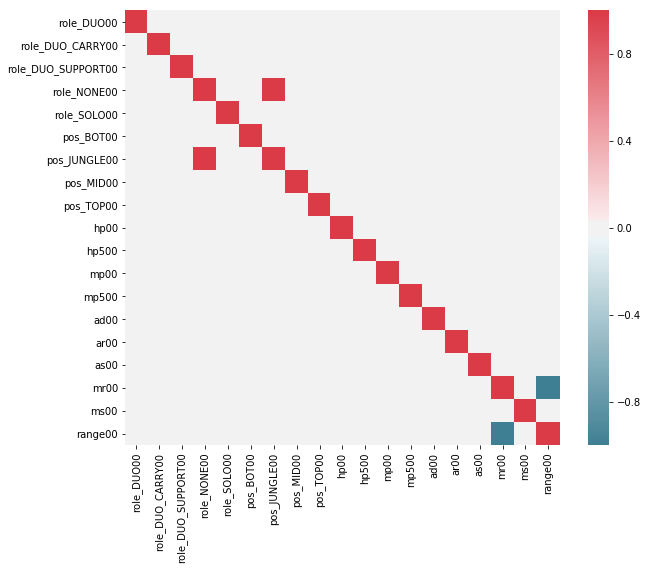

In [3]:
atr = dataset.columns.values.tolist()
corr = dataset[atr[0:19]].corr() * (0.5 / 0.7)
corr = corr.round(0)

f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, ax = ax)

del corr
del durationTerm
del killTerm
del kd0
del kd1
del win0
del win1
del champ_stats
del champs
del mtime
del participants
del stats1
del stats2
del stats

In [4]:
for i in range(2):
    for j in range(5):
        ij = str(i)+str(j)
        dataset.drop(columns = ['hp5'+ij, 'mr'+ij, 'role_NONE'+ij], inplace = True)

display(dataset)

,role_DUO00,role_DUO_CARRY00,role_DUO_SUPPORT00,role_SOLO00,pos_BOT00,pos_JUNGLE00,pos_MID00,pos_TOP00,hp00,mp00,...,mp514,ad14,ar14,as14,ms14,range14,kd_ratio0,kd_ratio1,dificult0,dificult1
0,0,0,0,0,0,1,0,0,0.560748,0.590109,...,0.32000,0.444805,0.489492,0.715395,0.625,0.761905,0.512821,1.950000,0.824999,0.175001
1,0,0,1,0,1,0,0,0,0.647975,0.669726,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,1.031250,0.969697,0.617202,0.382798
2,0,1,0,0,1,0,0,0,0.526106,0.703035,...,0.23512,0.457895,0.576271,0.946749,0.375,0.809524,0.625000,1.600000,0.870648,0.129352
3,0,0,0,1,0,0,1,0,0.635514,0.781191,...,0.24000,0.333333,0.495186,0.715395,0.250,0.809524,0.923077,1.083333,0.883500,0.116500
4,0,0,0,1,0,0,1,0,0.623053,0.625703,...,0.38000,0.516842,0.599729,0.727485,0.500,0.619048,1.085714,0.846154,0.610488,0.389512
5,0,1,0,0,1,0,0,0,0.529595,0.633046,...,0.00000,0.543860,0.610169,0.857657,0.750,0.095238,1.833333,0.545455,0.148776,0.851224
6,0,0,0,0,0,1,0,0,0.745421,0.628100,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,0.622222,1.607143,0.863009,0.136991
7,0,0,0,0,0,1,0,0,0.745421,0.628100,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,0.580645,1.722222,0.851710,0.148290
8,0,0,0,1,0,0,1,0,0.467290,0.669726,...,0.25800,0.400000,0.661017,0.840779,0.250,1.000000,0.820513,1.218750,0.873448,0.126552
9,0,0,0,1,0,0,0,1,0.771963,0.655676,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,1.600000,0.625000,0.133334,0.866666


##### Construindo conjuntos de treino e teste

In [5]:
new_io = dataset

print('Número de outliers antes do tratamento: ' + str(new_io.isnull().sum().sum()))
new_io = new_io.dropna()
print('Número de outliers após o tratamento: ' + str(new_io.isnull().sum().sum()))

params = new_io.columns.values.tolist()

team0win = new_io[new_io['dificult0'] < 0.25].filter(params[0:80])
team1win = new_io[new_io['dificult1'] < 0.25].filter(params[80:160])

del dataset
del new_io

# x = new_io.filter(params[0:160], axis = 1)
# y = new_io.filter(['dificult0', 'dificult1'], axis = 1)

finalDataset = DataSet()

for i in [0, 32]:
    print('\r'+str(i), end='\t')
    x = team0win.filter(params[0:i]+params[i+16:80], axis = 1)
    y = team0win.filter(params[i:i+16], axis = 1)

    for inst_x, inst_y in zip(x.iterrows(), y.iterrows()):
        index_x, data_x = inst_x
        index_y, data_y = inst_y
        finalDataset.add(Instance(data_x.tolist(), data_y.tolist()))

print("\nParte 1 OK\n\n")
del team0win

for i in [96, 144]:
    print('\r'+str(i), end='\t')
    x = team1win.filter(params[80:i]+params[i+16:160], axis = 1)
    y = team1win.filter(params[i:i+16], axis = 1)

    for inst_x, inst_y in zip(x.iterrows(), y.iterrows()):
        index_x, data_x = inst_x
        index_y, data_y = inst_y
        finalDataset.add(Instance(data_x.tolist(), data_y.tolist()))

print("\nParte 2 OK\n\n")
del team1win

print('Tamanho do dataset: ' + str(finalDataset.size()))

Número de outliers antes do tratamento: 3046
Número de outliers após o tratamento: 0
32	
Parte 1 OK


144	
Parte 2 OK


Tamanho do dataset: 270968


In [6]:
X = []
y = []
#random.choice(foo)

for inst in finalDataset.data():
    X.append(inst.input)
    y.append(inst.expected_output)

start_time = time.time()

neigh = knn(n_neighbors = 3, weights = 'distance', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 06:12
0.021002285753227705
Tempo total predict: 11:38


In [7]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 5, weights = 'distance', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 06:20
0.01928109396288187
Tempo total predict: 12:01


In [8]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 7, weights = 'distance', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

0.018569737713442565


In [9]:
del neigh
neigh = knn(n_neighbors = 51, weights = 'distance', algorithm = 'kd_tree', n_jobs = 2)
neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))

0.017210655133922496


In [10]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 21, weights = 'distance', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 06:11
0.01738724138305202
Tempo total predict: 12:37


In [11]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 101, weights = 'distance', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 06:06
0.01731888114865442
Tempo total predict: 14:07


In [12]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 3, weights = 'uniform', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 06:08
0.020862872072749925
Tempo total predict: 11:37


In [13]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 5, weights = 'uniform', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 06:14
0.019135838532171146
Tempo total predict: 12:21


In [14]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 7, weights = 'uniform', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 07:37
0.018441335999953394
Tempo total predict: 14:43


In [15]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 21, weights = 'uniform', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 08:09
0.017304603832543536
Tempo total predict: 15:59


In [16]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 51, weights = 'uniform', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 08:42
0.017175424389494928
Tempo total predict: 17:57


In [17]:
del neigh
start_time = time.time()

neigh = knn(n_neighbors = 101, weights = 'uniform', algorithm = 'kd_tree', n_jobs = 2)
elapsed_time = time.time() - start_time
print('Tempo total construção: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

neigh.fit(X[0:int(finalDataset.size()*0.8)], y[0:int(finalDataset.size()*0.8)])
elapsed_time = time.time() - start_time
print('Tempo total fit: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

print(mean_squared_log_error(neigh.predict(X[int(finalDataset.size()*0.8):]), y[int(finalDataset.size()*0.8):]))
elapsed_time = time.time() - start_time
print('Tempo total predict: ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))

Tempo total construção: 00:00
Tempo total fit: 08:39
0.017320742747772688
Tempo total predict: 17:33
